In [17]:
import torch
import gpytorch
import matplotlib.pyplot as plt

from msc.dataset.dataset import SeizuresDataset, UniformDataset
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define the model

In [18]:
class EEGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(EEGGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cover_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()



## Sample from the prior

In [19]:
times = torch.linspace(1, 10, 1000)


In [20]:
times

tensor([ 1.0000,  1.0090,  1.0180,  1.0270,  1.0360,  1.0450,  1.0541,  1.0631,
         1.0721,  1.0811,  1.0901,  1.0991,  1.1081,  1.1171,  1.1261,  1.1351,
         1.1441,  1.1532,  1.1622,  1.1712,  1.1802,  1.1892,  1.1982,  1.2072,
         1.2162,  1.2252,  1.2342,  1.2432,  1.2523,  1.2613,  1.2703,  1.2793,
         1.2883,  1.2973,  1.3063,  1.3153,  1.3243,  1.3333,  1.3423,  1.3514,
         1.3604,  1.3694,  1.3784,  1.3874,  1.3964,  1.4054,  1.4144,  1.4234,
         1.4324,  1.4414,  1.4505,  1.4595,  1.4685,  1.4775,  1.4865,  1.4955,
         1.5045,  1.5135,  1.5225,  1.5315,  1.5405,  1.5495,  1.5586,  1.5676,
         1.5766,  1.5856,  1.5946,  1.6036,  1.6126,  1.6216,  1.6306,  1.6396,
         1.6486,  1.6577,  1.6667,  1.6757,  1.6847,  1.6937,  1.7027,  1.7117,
         1.7207,  1.7297,  1.7387,  1.7477,  1.7568,  1.7658,  1.7748,  1.7838,
         1.7928,  1.8018,  1.8108,  1.8198,  1.8288,  1.8378,  1.8468,  1.8559,
         1.8649,  1.8739,  1.8829,  1.89

In [21]:
model = EEGGPModel([],[], likelihood)
model

EEGGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

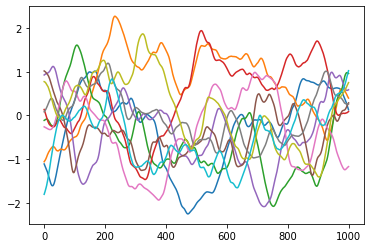

In [22]:
for i in range(10):
    plt.plot(model(times).sample())

In [23]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [24]:
train_x = times
train_y = 2*model(times).sample()


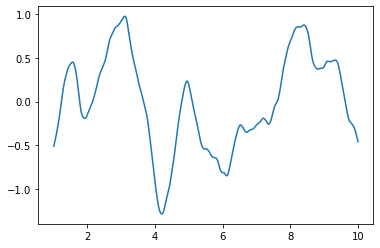

In [25]:
plt.plot(train_x, (train_y - train_y.mean())/(torch.var(train_y - train_y.mean())))

In [26]:
def training_loop(train_x, train_y, num_iters=50, lr=0.01):
    model = EEGGPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_iters):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, num_iters, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

    results = pd.DataFrame(model.named_parameters(), columns=["param_name", "param_value"])
    results['param_value'] = params.param_value.apply(lambda x: x.item())
    return params

training_loop(train_x, train_y)

Iter 1/50 - Loss: 0.864   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.862   lengthscale: 0.688   noise: 0.688
Iter 3/50 - Loss: 0.856   lengthscale: 0.683   noise: 0.683
Iter 4/50 - Loss: 0.844   lengthscale: 0.678   noise: 0.678
Iter 5/50 - Loss: 0.847   lengthscale: 0.673   noise: 0.673
Iter 6/50 - Loss: 0.841   lengthscale: 0.669   noise: 0.669
Iter 7/50 - Loss: 0.833   lengthscale: 0.664   noise: 0.664
Iter 8/50 - Loss: 0.834   lengthscale: 0.659   noise: 0.659
Iter 9/50 - Loss: 0.832   lengthscale: 0.654   noise: 0.654
Iter 10/50 - Loss: 0.822   lengthscale: 0.649   noise: 0.649
Iter 11/50 - Loss: 0.821   lengthscale: 0.645   noise: 0.644
Iter 12/50 - Loss: 0.814   lengthscale: 0.640   noise: 0.640
Iter 13/50 - Loss: 0.814   lengthscale: 0.636   noise: 0.635
Iter 14/50 - Loss: 0.803   lengthscale: 0.631   noise: 0.630
Iter 15/50 - Loss: 0.806   lengthscale: 0.627   noise: 0.626
Iter 16/50 - Loss: 0.798   lengthscale: 0.622   noise: 0.621
Iter 17/50 - Loss: 0.791   length

,param_name,value
0,likelihood.noise_covar.raw_noise,-0.506723
1,mean_module.constant,0.003399
2,covar_module.raw_outputscale,0.439708
3,covar_module.base_kernel.raw_lengthscale,-0.402685


## Load Data

In [27]:
data_dir = r"C:\Users\noam\Repositories\noamsgl\msc\results\epilepsiae\UNIFORM\20220106T165558"
dataset = UniformDataset(data_dir)
times = dataset.get_train_x()
samples = dataset.get_train_y(num_channels=1).float()

loading
done loading


In [28]:
samples.dtype

torch.float32

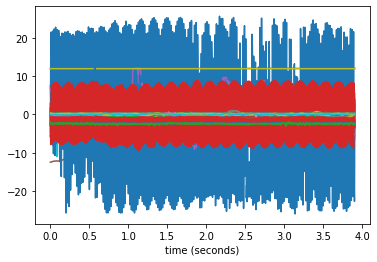

In [29]:
for i in range(1000):
    plt.plot(times, samples[i][0])
plt.xlabel('time (seconds)')
plt.show()

## MLE Hyperparameter estimation

In [30]:
def train_model_multiple_times(train_x, train_y, num_iters=50, lr=0.01):
    params_results = []
    for i in range(train_y.shape[0]):
        print(f"**** training loop {i=} ****")
        results = training_loop(train_x, train_y[i], num_iters=num_iters, lr=lr)
        results["sample_id"] = i
        params_results.append(results)
    results_df = pd.concat(params_results)
    return results_df

In [32]:
params = train_model_multiple_times(train_x, samples.squeeze()[:100])

**** training loop i=0 ****
Iter 1/50 - Loss: -1.629   lengthscale: 0.693   noise: 0.002
Iter 2/50 - Loss: -1.628   lengthscale: 0.688   noise: 0.002
Iter 3/50 - Loss: -1.619   lengthscale: 0.688   noise: 0.002
Iter 4/50 - Loss: -1.663   lengthscale: 0.688   noise: 0.002
Iter 5/50 - Loss: -1.621   lengthscale: 0.690   noise: 0.002
Iter 6/50 - Loss: -1.618   lengthscale: 0.692   noise: 0.002
Iter 7/50 - Loss: -1.613   lengthscale: 0.694   noise: 0.002
Iter 8/50 - Loss: -1.636   lengthscale: 0.696   noise: 0.002
Iter 9/50 - Loss: -1.635   lengthscale: 0.696   noise: 0.002
Iter 10/50 - Loss: -1.657   lengthscale: 0.697   noise: 0.002
Iter 11/50 - Loss: -1.666   lengthscale: 0.697   noise: 0.002
Iter 12/50 - Loss: -1.640   lengthscale: 0.698   noise: 0.002
Iter 13/50 - Loss: -1.669   lengthscale: 0.696   noise: 0.002
Iter 14/50 - Loss: -1.637   lengthscale: 0.694   noise: 0.002
Iter 15/50 - Loss: -1.663   lengthscale: 0.692   noise: 0.002
Iter 16/50 - Loss: -1.647   lengthscale: 0.691   no

<AxesSubplot:ylabel='Frequency'>

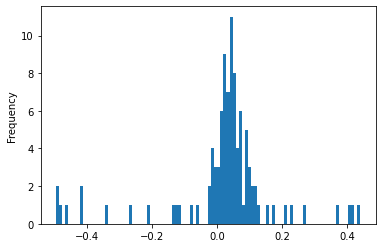

In [45]:
params.groupby('param_name').get_group('mean_module.constant').value.plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

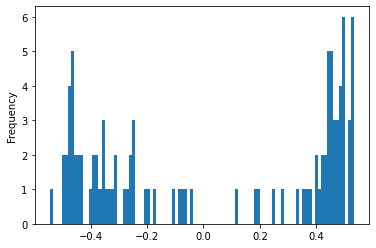

In [46]:
params.groupby('param_name').get_group('covar_module.raw_outputscale').value.plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

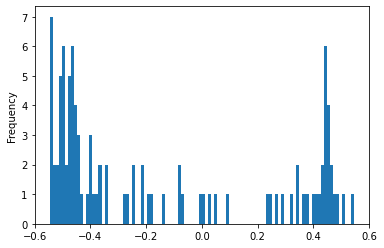

In [47]:
params.groupby('param_name').get_group('covar_module.base_kernel.raw_lengthscale').value.plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

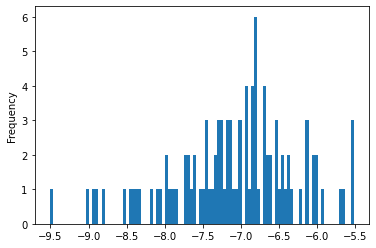

In [50]:
params.groupby('param_name').get_group('likelihood.noise_covar.raw_noise').value.plot(kind='hist', bins=100)

In [49]:
params

,param_name,value,sample_id
0,likelihood.noise_covar.raw_noise,-6.669262,0
1,mean_module.constant,-0.000155,0
2,covar_module.raw_outputscale,-0.315278,0
3,covar_module.base_kernel.raw_lengthscale,-0.138727,0
0,likelihood.noise_covar.raw_noise,-7.165708,1
...,...,...,...
3,covar_module.base_kernel.raw_lengthscale,-0.476190,98
0,likelihood.noise_covar.raw_noise,-6.940012,99
1,mean_module.constant,-0.081022,99
2,covar_module.raw_outputscale,0.408791,99
